In [2]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [5]:
test_labels = np.load('../data/labels/test_labels.npy')
train_tracks = np.load("../data/tracks/train_tracks.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

train_tracks_features = train_tracks[:, 0, 4:17] 
test_tracks_features = test_tracks[:, 0, 4:17]

In [6]:
train_tracks_features.shape, test_tracks_features.shape

((1108, 13), (277, 13))

In [31]:
train_tracks_features[0, 8]

12.815924

In [32]:
train_tracks_features[0]

array([8.8405502e-01, 4.1251654e+02, 3.8137009e+02, 1.0466557e+02,
       9.0447464e+01, 1.3879191e+01, 1.1952522e+01, 5.0829524e-01,
       1.2815924e+01, 3.7902000e+01, 7.9388660e+02, 1.2900000e+02,
       1.1611936e+00], dtype=float32)

In [43]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


# Define config
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'n_feature_pairs': 30  # number of random feature pairs to test
}

# Set seed
tf.keras.utils.set_random_seed(config['seed'])
np.random.seed(config['seed'])

# Initialize container for confusion matrices
conf_matrix_tabular = np.zeros((config['n_feature_pairs'], 2, 2))

# Loop over N random feature combinations
for i in range(config['n_feature_pairs']):
    # Pick 2 random features
    selected_features = np.random.choice(13, size=2, replace=False)
    print(f"Run {i+1} — Using features: {selected_features}")

    # Subset the data
    X_train = train_tracks_features[:, selected_features]
    X_test = test_tracks_features[:, selected_features]

    # Train/val split
    X_val, X_test_final, y_val, y_test_final = train_test_split(X_test, test_labels, test_size=0.5, random_state=42)

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    # Build model
    classifier = complex_mlp_classifier(latent_dim=2)
    classifier.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
                       metrics=['accuracy'])

    # Train
    classifier.fit(X_train, train_labels,
                   batch_size=config['batch_size'],
                   epochs=config['epochs'],
                   validation_data=(X_val, y_val),
                   class_weight=class_weights,
                   verbose=0)

    # Predict
    y_pred = classifier.predict(X_test_final, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test_final, y_pred_classes)
    cm_normalized = cm / cm.sum(axis=1, keepdims=True)

    conf_matrix_tabular[i] = cm_normalized

# Save results
np.save("confusion_matrices_random_feature_selection.npy", conf_matrix_tabular)
print(f"\nSaved confusion matrices for {config['n_feature_pairs']} random feature combinations.")


Run 1 — Using features: [11  9]
Run 2 — Using features: [ 8 10]
Run 3 — Using features: [12 10]
Run 4 — Using features: [9 1]
Run 5 — Using features: [0 5]
Run 6 — Using features: [8 9]
Run 7 — Using features: [4 2]
Run 8 — Using features: [11  2]
Run 9 — Using features: [5 1]
Run 10 — Using features: [11  9]


2025-03-21 15:10:56.842791: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [2,32] vs. [0]
	 [[{{function_node __inference_one_step_on_data_663411}}{{node adam/truediv_5}}]]


InvalidArgumentError: Graph execution error:

Detected at node adam/truediv_5 defined at (most recent call last):
  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_36621/501072783.py", line 49, in <module>

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 73, in train_step

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 291, in apply_gradients

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 356, in apply

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 419, in _backend_apply_gradients

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/backend/tensorflow/optimizer.py", line 121, in _backend_update_step

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/backend/tensorflow/optimizer.py", line 135, in _distributed_tf_update_step

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/backend/tensorflow/optimizer.py", line 132, in apply_grad_to_update_var

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/optimizers/adam.py", line 147, in update_step

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 5553, in divide

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/backend/tensorflow/sparse.py", line 780, in sparse_wrapper

  File "/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 2246, in divide

Incompatible shapes: [2,32] vs. [0]
	 [[{{node adam/truediv_5}}]] [Op:__inference_one_step_on_iterator_663498]

In [11]:
conf_matrix_tabular.shape

(30, 2, 2)

In [40]:
precision_tabular = np.zeros((30))
accuracy_tabular = np.zeros((30))
false_positives_tabular = np.zeros((30))
false_negatives_tabular = np.zeros((30))

for size in range(conf_matrix_tabular.shape[0]):
    conf_matrix = conf_matrix_tabular[size]
    precision_tabular[size] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    accuracy_tabular[size] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
    false_positives_tabular[size] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
    false_negatives_tabular[size] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [16]:
np.arange(1, 31).shape

(30,)

In [ ]:
# np.save("precision_2feattabular.npy", precision_tabular)
# np.save("accuracy_2feattabular.npy", accuracy_tabular)
# np.save("false_positives_2feattabular.npy", false_positives_tabular)
# np.save("false_negatives_2feattabular.npy", false_negatives_tabular)

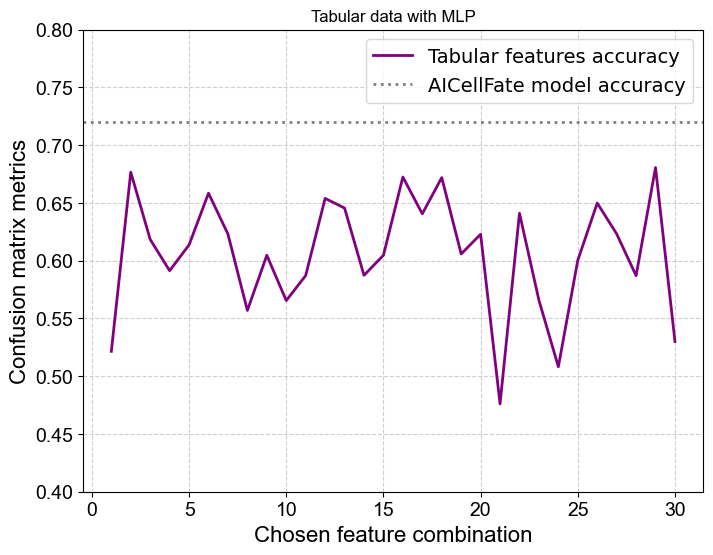

In [41]:
feature_pairs = np.arange(1, 31)

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
#plt.plot(feature_pairs, precision_tabular, color='orange', linewidth=2, label='Precision')

# Accuracy (purple)
plt.plot(feature_pairs, accuracy_tabular, color='purple', linewidth=2, label='Tabular features accuracy')

# Add horizontal dotted line for AICellFate model precision
#plt.axhline(y=0.745, color='orange', linestyle='dotted', linewidth=2, label='AICellFate model precision')
plt.axhline(y=0.72, color='gray', linestyle='dotted', linewidth=2, label='AICellFate model accuracy') ### this is the mean precision value from AICellFate on the first frame

# # False Positives (green)
# plt.plot(feature_pairs, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# # False Negatives (blue)
# plt.plot(feature_pairs, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Chosen feature combination", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.4, 0.8)  # Set y-axis range
plt.title("Tabular data with MLP")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("accuracy_comparison.svg", dpi=300, bbox_inches="tight")
plt.show()

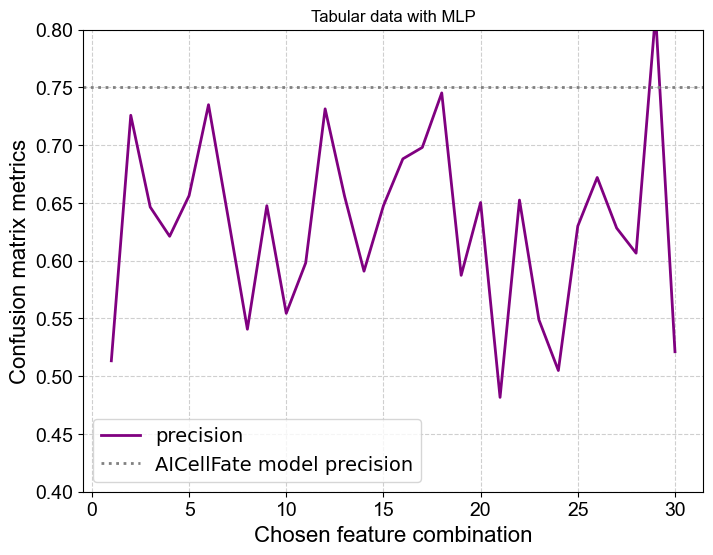

In [42]:
feature_pairs = np.arange(1, 31)

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
#plt.plot(feature_pairs, precision_tabular, color='orange', linewidth=2, label='Precision')

# Accuracy (purple)
plt.plot(feature_pairs, precision_tabular, color='purple', linewidth=2, label='precision')

# Add horizontal dotted line for AICellFate model precision
#plt.axhline(y=0.745, color='orange', linestyle='dotted', linewidth=2, label='AICellFate model precision')
plt.axhline(y=0.75, color='gray', linestyle='dotted', linewidth=2, label='AICellFate model precision') ### this is the mean precision value from AICellFate on the first frame

# # False Positives (green)
# plt.plot(feature_pairs, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# # False Negatives (blue)
# plt.plot(feature_pairs, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Chosen feature combination", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.4, 0.8)  # Set y-axis range
plt.title("Tabular data with MLP")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("precision_comparison.svg", dpi=300, bbox_inches="tight")
plt.show()